# Understanding the effect of Housing Prices based on Clustered Neighborhoods <br><br> in King County, USA
<br>

Let us import the required libraries first.

In [3]:
import pandas as pd
import numpy as np

# To create maps
import folium
from geopy.geocoders import Nominatim

# To handle API requests made to Foursquare
import requests

# Use json_normalize to convert JSON data to pandas dataframe
from pandas.io.json import json_normalize

# KMeans algorithm
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# Plotting matplotlib and required libraries for plotting
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix

# Importing Sys library for displaying percentage complete
import sys


<H1><font color='SteelBlue'>Exploratory Data Analysis</H1>
<H3>Loading the datasets</H3>
<br><br>

The dataset has been taken from Kaggle and is widely used for a hands-on experience on training regression models. We will leverage this dataset to add another feature to it and understand if we can find correlations between housing prices and the clusters of neighborhoods that we will be creating further in this project. 

In [4]:
pd.set_option('display.max_columns', 500)
kc_house_data = pd.read_csv('housesalesprediction/kc_house_data.csv')

Now, since we have imported the dataset, let us explore around a bit.

In [5]:
kc_house_data.shape

(21613, 21)

We have 21 columns and 21613 rows in the dataset. Let us see how a sample of it looks like.

In [6]:
kc_house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [7]:
kc_house_data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [6]:
kc_house_data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Here, price is the target value and all the following columns can be used as features. The columns id and date do not have much relevance, hence, we can drop those columns.<br>
(The column date describes the date when the housing price value was recorded. On analyzing the dataset, we found that most of the dates belong to the year 2014-15. For learning purpose, we are assuming that the prices would still be the same and the venues in the neighborhoods(districts here) have grown proportionately).

In [11]:
kc_house_data.drop(columns=['id', 'date'], inplace=True)

Now, lets take a quick glance at the histograms for the numeric columns and try to understand the distributions for each of the features.<br>
However, the two major columns that we are interested in are 'price' and zipcode. But we will just take a short look at each of the features for educational purpose. Also, it is really interesting to look at the histograms as they reveal the distribution - whether it is normally distributed and if it is heavy on the either sides or if it follows a different pattern altogether.

In [9]:
kc_house_data['bathrooms'].unique()

array([1.  , 2.25, 3.  , 2.  , 4.5 , 1.5 , 2.5 , 1.75, 2.75, 3.25, 4.  ,
       3.5 , 0.75, 4.75, 5.  , 4.25, 3.75, 0.  , 1.25, 5.25, 6.  , 0.5 ,
       5.5 , 6.75, 5.75, 8.  , 7.5 , 7.75, 6.25, 6.5 ])

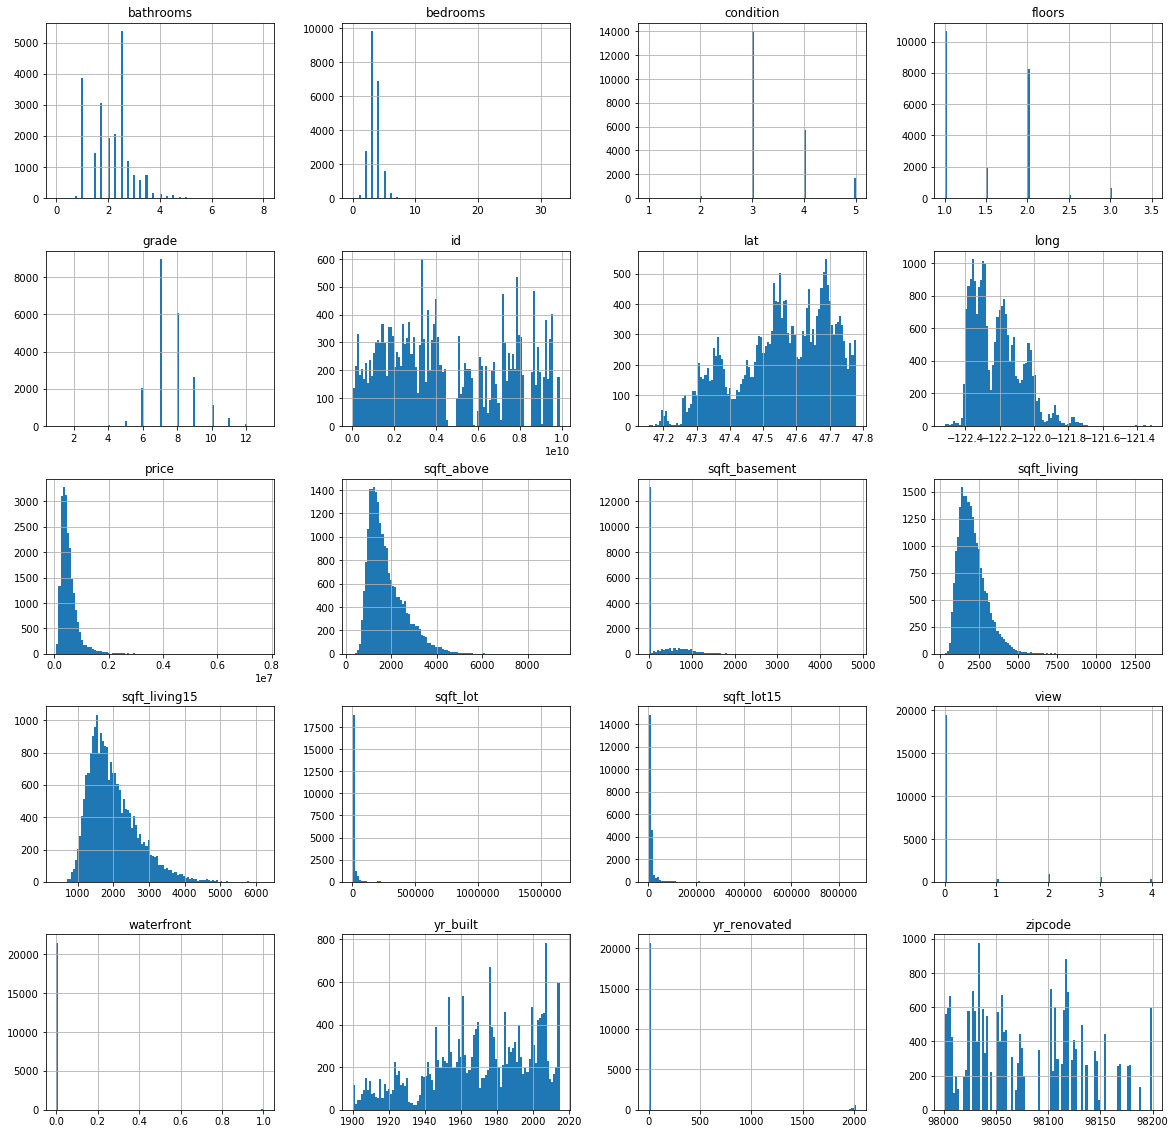

In [8]:
kc_house_data.hist(bins=100,figsize=(20,20))
plt.plot()

plt.savefig('hist.png')

For most of the distrinbutions, we see that they are tail heavy. 

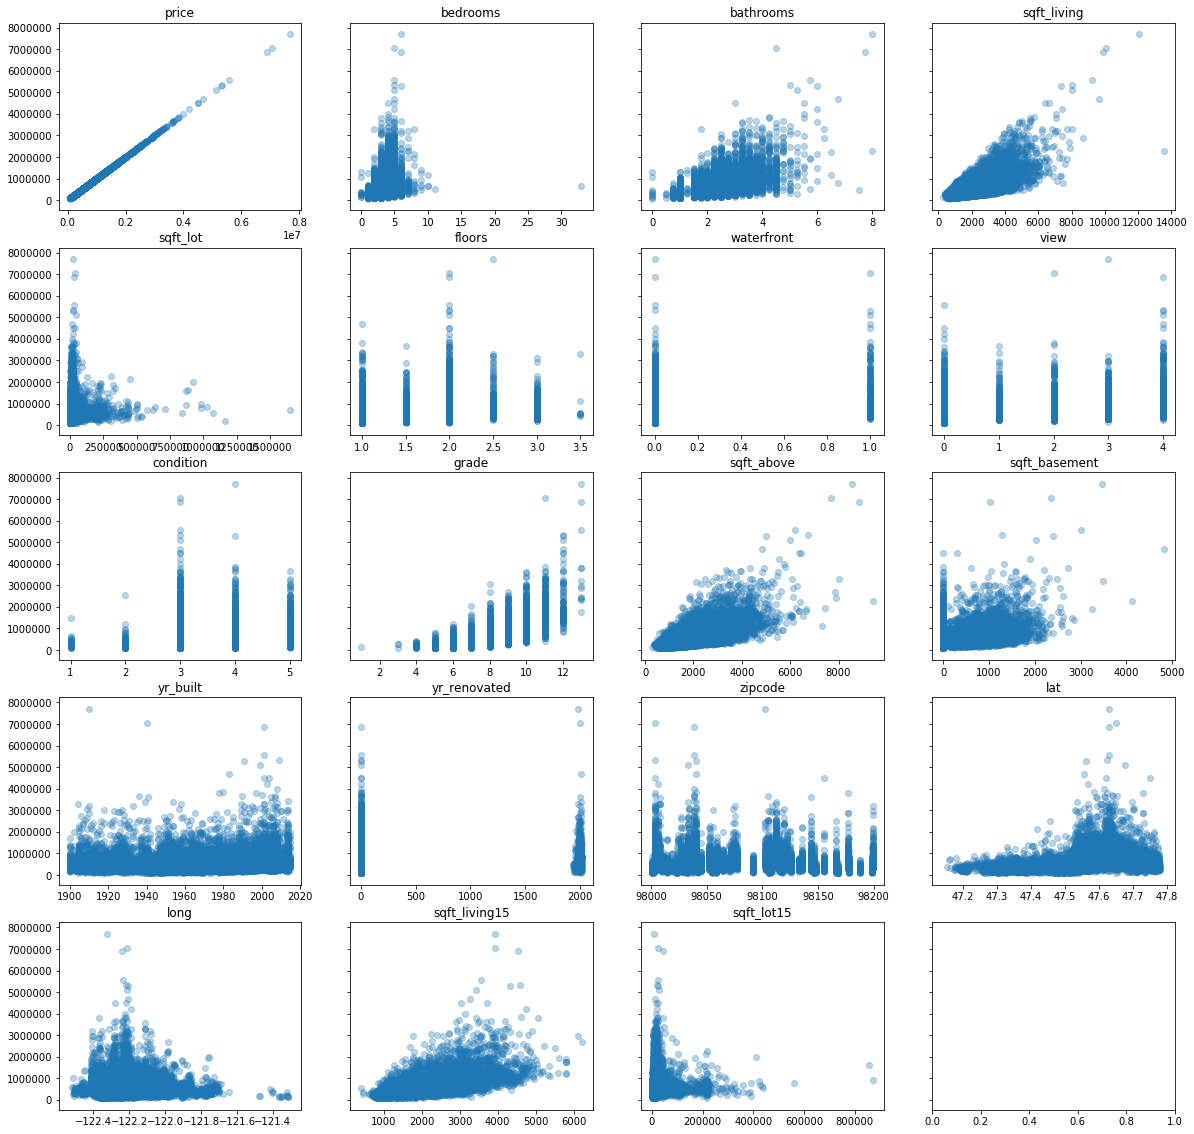

In [12]:
fig, ax = plt.subplots(5,4, sharey=True, figsize=(20,20))

for i, j in enumerate(kc_house_data.columns):
    ax[i//4,i%4].scatter(kc_house_data[j],kc_house_data['price'], alpha=0.3)
    ax[i//4,i%4].set_title(j)
plt.show()

<H3> Analyze ZipCodes</H3>

The most important column for our project is the column 'zipcode'. Let us try to find the unique number of zipcodes that we have and later group our entire dataset according to zipcode.

In [13]:
len(kc_house_data['zipcode'].unique())

70

In [14]:
zipcode_data = kc_house_data.groupby('zipcode').mean().sort_values(by='price', ascending=False)

In [15]:
zipcode_data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
zipcode,,,,,,,,,,,,,,,,,,
98039,2.160607e+06,4.060000,3.200000,3800.900000,17403.560000,1.560000,0.020000,0.440000,3.480000,9.560000,3290.900000,510.000000,1972.520000,398.600000,47.625840,-122.233540,3132.200000,17291.100000
98004,1.355927e+06,3.854890,2.527603,2909.022082,13104.220820,1.432177,0.003155,0.305994,3.495268,8.687697,2419.842271,489.179811,1971.470032,208.145110,47.616183,-122.205189,2674.700315,12805.022082
98040,1.194230e+06,4.028369,2.716312,3106.833333,13704.464539,1.505319,0.042553,0.783688,3.787234,8.960993,2474.329787,632.503546,1971.471631,233.574468,47.559846,-122.225592,2898.744681,12801.283688
98112,1.095499e+06,3.509294,2.373606,2498.743494,4990.431227,1.806691,0.000000,0.148699,3.516729,8.442379,2005.695167,493.048327,1944.449814,223.144981,47.629619,-122.297866,2280.078067,4898.159851
98102,9.012583e+05,3.219048,2.261905,2159.742857,3616.190476,2.004762,0.000000,0.171429,3.371429,8.285714,1764.933333,394.809524,1952.523810,113.923810,47.634607,-122.322248,1958.333333,3310.133333


<H3> Find coordinates for the zip_codes



Now, when we have the zipcodes, let us try to find the coordinates for each of them using __geolocator__ library and put it together into a dataframe. We will further be using these coordinates to explore nearby venues using Foursquare APIs.

In [16]:
zip_codes = kc_house_data['zipcode'].unique()

In [17]:
zipcode_coo = pd.DataFrame(columns=['zipcode', 'lat', 'lon'])
geolocator = Nominatim(user_agent='kc_zipcode')
total = len(zip_codes)
for count,i in enumerate(zip_codes):
    
    address = str(i) + ', USA'
    location = None
    while location is None:
        try:
            location = geolocator.geocode(address)
        except:
            pass

    lat = location.latitude
    lon = location.longitude
    row = [i, lat, lon]
    
    #print(row)
    
    zipcode_coo.loc[count,'zipcode'] = i
    zipcode_coo.loc[count,'lat'] = lat
    zipcode_coo.loc[count,'lon'] = lon
    
    percent = round(((count+1)/total)*100,2)
    sys.stdout.write("%-7s %s complete\r" %(percent, '%'))
    sys.stdout.flush()


In [18]:
zipcode_coo.head()

,zipcode,lat,lon
0,98178,47.4986,-122.248
1,98125,47.7215,-122.305
2,98028,47.7569,-122.242
3,98136,47.539,-122.389
4,98074,47.6143,-122.036


First let us plot the coordinates of the zipcodes to have an idea how the map looks like. 

In [19]:
kc_location = geolocator.geocode("King County, USA")
kc_lat = kc_location.latitude
kc_long = kc_location.longitude
kc_map = folium.Map(location=[kc_lat,kc_long], zoom_start=9)

for idx, row in zipcode_coo.iterrows():
    folium.CircleMarker(location=[row.lat, row.lon], 
                        radius=3, fill=True, popup=str(row.zipcode), 
                        color='Blue', fill_color='Blue', fill_opacity=1).add_to(kc_map)
    
kc_map

<h1><font color='SteelBlue'>Connecting with Foursquare</h1>

Now, since we have the coordinates, lets analyze the neighborhoods for each of the zipcodes using Foursquare data. We will then cluster the areas defined by zipcodes and later try to find if neighborhood has any impact on prices or not.

In [24]:
# Connection parameters for Foursquare API

CLIENT_ID = 'RGCS4PAOYAAUQTN3ZARIVIE4YV4U3U5BCODVVRAP4ONWJHLV' # your Foursquare ID
CLIENT_SECRET = '4IUJ2SWB3AEJY0IR4W5JBEOLI5330TY2MTUMH5OZPCRB31TP' # your Foursquare Secret
VERSION = '20150605' # Foursquare API version

radius=1000
LIMIT=100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    total = len(names) - 1
    for i, (name, lat, lng) in enumerate(zip(names, latitudes, longitudes)):
        
        percent = round((i/total)*100, 2)
        sys.stdout.write('%-7s \r' %(percent))
        sys.stdout.flush()
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
kc_venues = getNearbyVenues(zipcode_coo['zipcode'], zipcode_coo['lat'], zipcode_coo['lon'])

In [25]:
len(kc_venues['Neighborhood'].unique())

65

We observe that out of 70 zipcodes, we only have neighborhood data for 65 of them. Hence, while analyzing data for all neighborhoods, we will omit data for the five zipcodes for which we dont have the neighborhood data.

In [26]:
print('There are {} uniques categories.'.format(len(kc_venues['Venue Category'].unique())))

There are 195 uniques categories.


Now, we can see that there are 195 categories for the venues. We will be using KMeans clustering algorithm for our project. For the algorithm, the input feed needs to be in a format, where we have each of the 195 venues as features and a value for each parameter which indicates how strong the feature is. Hence, to achieve this, we can simply use one hot encoding to convert our data set into the required format and then for each neighborhood, calculate the mean for each of the features.<br>
The below steps perform the same.

In [27]:
# one hot encoding
kc_onehot = pd.get_dummies(kc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kc_onehot['Neighborhood'] = kc_venues['Neighborhood'] 

# move neighborhood column to the first column
col_list = list(kc_onehot.columns)
col_list.remove('Neighborhood')
fixed_columns = ["Neighborhood"] + col_list
kc_onehot = kc_onehot[fixed_columns]

In [28]:
kc_onehot.head()

,Neighborhood,ATM,Accessories Store,Alternative Healer,American Restaurant,Antique Shop,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Store,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brewery,Bubble Tea Shop,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Café,Campground,Candy Store,Caribbean Restaurant,Carpet Store,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Credit Union,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Eye Doctor,Farmers Market,Fast Food Restaurant,Fish Market,Flower Shop,Food,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Hawaiian Restaurant,Herbs & Spices Store,History Museum,Home Service,Hotel,IT Services,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Lingerie Store,Liquor Store,Locksmith,Marijuana Dispensary,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Store,Music Venue,New American Restaurant,Noodle House,Optical Shop,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Park,Pawn Shop,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Post Office,Pub,Ramen Restaurant,Rental Car Location,Restaurant,River,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Stables,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trade School,Trail,Tree,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,98178,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,98178,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,98178,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,98178,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [29]:
kc_grouped = kc_onehot.groupby('Neighborhood').mean().reset_index()
kc_grouped.shape

(65, 196)

We can have a quick look as how many total venues do we have for each of the neighborhood.

In [30]:
kc_grouped_by_count = kc_onehot.groupby('Neighborhood').count().reset_index()
kc_grouped_by_count['ATM'].value_counts()

4      9
3      8
5      8
1      6
2      6
7      4
9      4
6      3
10     3
19     2
11     1
100    1
43     1
17     1
18     1
21     1
23     1
27     1
29     1
30     1
36     1
12     1
Name: ATM, dtype: int64

In [31]:
kc_grouped.head()

,Neighborhood,ATM,Accessories Store,Alternative Healer,American Restaurant,Antique Shop,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Store,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brewery,Bubble Tea Shop,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Café,Campground,Candy Store,Caribbean Restaurant,Carpet Store,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Credit Union,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Eye Doctor,Farmers Market,Fast Food Restaurant,Fish Market,Flower Shop,Food,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Hawaiian Restaurant,Herbs & Spices Store,History Museum,Home Service,Hotel,IT Services,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Lingerie Store,Liquor Store,Locksmith,Marijuana Dispensary,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Store,Music Venue,New American Restaurant,Noodle House,Optical Shop,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Park,Pawn Shop,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Post Office,Pub,Ramen Restaurant,Rental Car Location,Restaurant,River,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Stables,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trade School,Trail,Tree,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,98001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,98002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

<H1><font color='SteelBlue'>Clustering

Now, we have our data ready to be fed into the KMeans machine learning algorithm. This is an unsupervised learning approach where the data is segmented into **k** clusters in which each data point belongs to the nearest mean. Here, our clustering will be based on the types of venues in a particular neighborhood, i.e., how similar are neighborhoods based on the most common venues they have.<br><br>
Even when the algorithm is unsupervised, we do need to provide the number of clusters that the dataset will be divided into, which can be a really hard problem to solve. Hence, we will take a step further and run our clustering algorithm for clusters witin the range 1-9 and try to find out the optimum value of clusters that we need to provide.

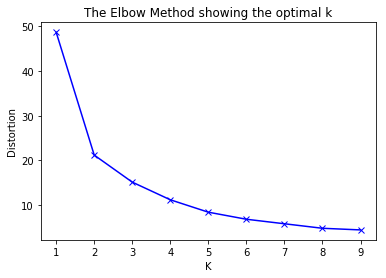

In [32]:
distortions = []
K = range(1,10)
X = kc_grouped

for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-', label=("Top %s venues" %i), c='Blue')
plt.ylabel('Distortion')
plt.xlabel('K')
plt.title('The Elbow Method showing the optimal k')
plt.show()
#print(i,nsteps,color)

By the elbow method, we can clearly see that we have the elbow point at 2. Hence, we will proceed with 2 as the number of clusters we would be dividing our dataset into. Let us see how good the clusters are:

In [33]:
# set number of clusters
kclusters = 2

kc_clustering_df = kc_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=2).fit(kc_clustering_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

# add clustering labels
#neighborhoods_venue_names_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


kc_labels = pd.Series(kmeans.labels_)
kc_labels.value_counts()

1    63
0     2
dtype: int64

Okay! Our algorithm did divide the dataset into two clusters, but the disparity is huge. This is clearly due to lack of data and we cannot efficiently say if we would be able to see a reliable correlation between these clusters and prices.<br><br>
Let us take a step further and try to find out how we can get better clusters, and maybe more clusters with better distributions.<br><br>
Since we have limited data, one approach would be to pass just a limited number of venues instead of all the 195 venues. Hence, we can just pick __top n__  venues and run our algorithm on it. Further, we will plot the elbow curves to determine the optimum number of top n venues and also the optimum number of clusters that we need to feed to our algorithm to get better results. Below steps do exactly the same:

In [34]:
def return_most_common_venue_names(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
    #return row_categories_sorted.values[0:num_top_venues]

def return_most_common_venue_values(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    #return row_categories_sorted.index.values[0:num_top_venues]
    return row_categories_sorted.values[0:num_top_venues]

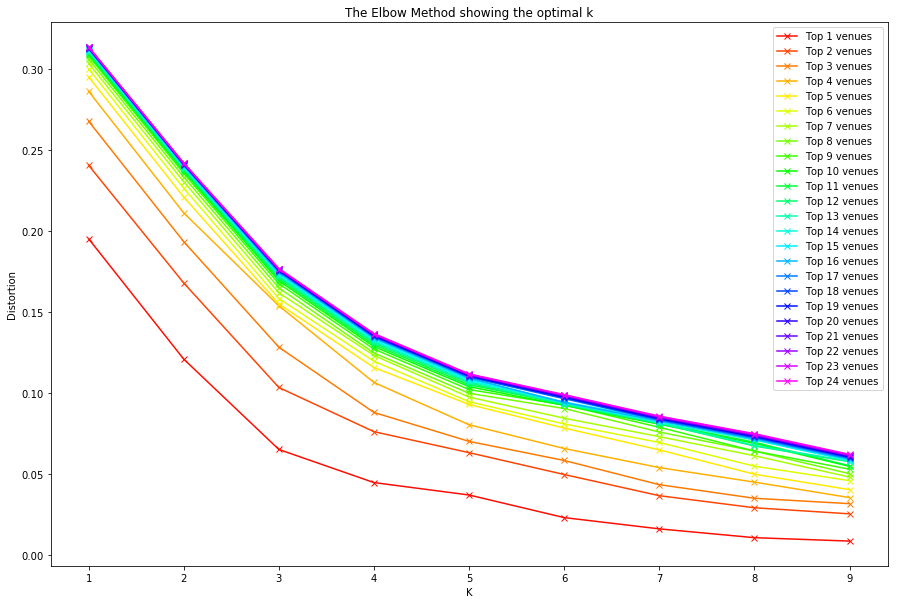

In [39]:
top_n_venue_max = 25
fig = plt.figure(figsize=(15,10))
cmap = cm.gist_rainbow
for i in range(1,top_n_venue_max):
    num_top_venues = i
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))
            
    neighborhoods_venue_values_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venue_values_sorted['Neighborhood'] = kc_grouped['Neighborhood']

    for ind in np.arange(kc_grouped.shape[0]):
        neighborhoods_venue_values_sorted.iloc[ind, 1:] = return_most_common_venue_values(kc_grouped.iloc[ind, :], num_top_venues)

    distortions = []
    K = range(1,10)
    X = kc_clustering_df = neighborhoods_venue_values_sorted.drop('Neighborhood', 1)

    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X)
        kmeanModel.fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    # Plot the elbow
    color = cmap(i/float(top_n_venue_max))
    plt.plot(K, distortions, 'bx-', label=("Top %s venues" %i), c=color)
    #print(i,nsteps,color)

plt.ylabel('Distortion')
plt.xlabel('K')
plt.title('The Elbow Method showing the optimal k')
plt.legend()
plt.savefig('elbows.png')
plt.show()

This looks great! On looking closely we can see that we have two good elbow points:

- Top 2 venues and 3 clusters
- Top 3 venues and 4 clusters

Considering the fact that we have limited data, lets go with the first option(it won't hurt to select the second option too) and run our algorithm on these two parameters.

In [40]:
num_top_venues = 2

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe to contain the names of top n venues
neighborhoods_venue_names_sorted = pd.DataFrame(columns=columns)
neighborhoods_venue_names_sorted['Neighborhood'] = kc_grouped['Neighborhood']

for ind in np.arange(kc_grouped.shape[0]):
    neighborhoods_venue_names_sorted.iloc[ind, 1:] = return_most_common_venue_names(kc_grouped.iloc[ind, :], num_top_venues)

# create a new dataframe to contain the values of top n venues
neighborhoods_venue_values_sorted = pd.DataFrame(columns=columns)
neighborhoods_venue_values_sorted['Neighborhood'] = kc_grouped['Neighborhood']

for ind in np.arange(kc_grouped.shape[0]):
    neighborhoods_venue_values_sorted.iloc[ind, 1:] = return_most_common_venue_values(kc_grouped.iloc[ind, :], num_top_venues)

#neighborhoods_venue_names_sorted

In [41]:
# set number of clusters
kclusters = 3

kc_clustering_df = neighborhoods_venue_values_sorted.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=2).fit(kc_clustering_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

# add clustering labels
neighborhoods_venue_names_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


kc_labels = pd.Series(kmeans.labels_)
kc_labels.value_counts()

1    35
0    24
2     6
dtype: int64

Great! These clusters look better than the one that we generated using the entire dataset. Clearly, the disparity is low and we are expecting the clusters to make some sense as well. Let us explore further to understand if these clusters do indicate a type of neighborhood or not.<br><br>
We would create a bar graph for each of the clusters with frequencies of the the type of venue that they contain and try to understand the clusters:

<H1><font color='SteelBlue'> Results

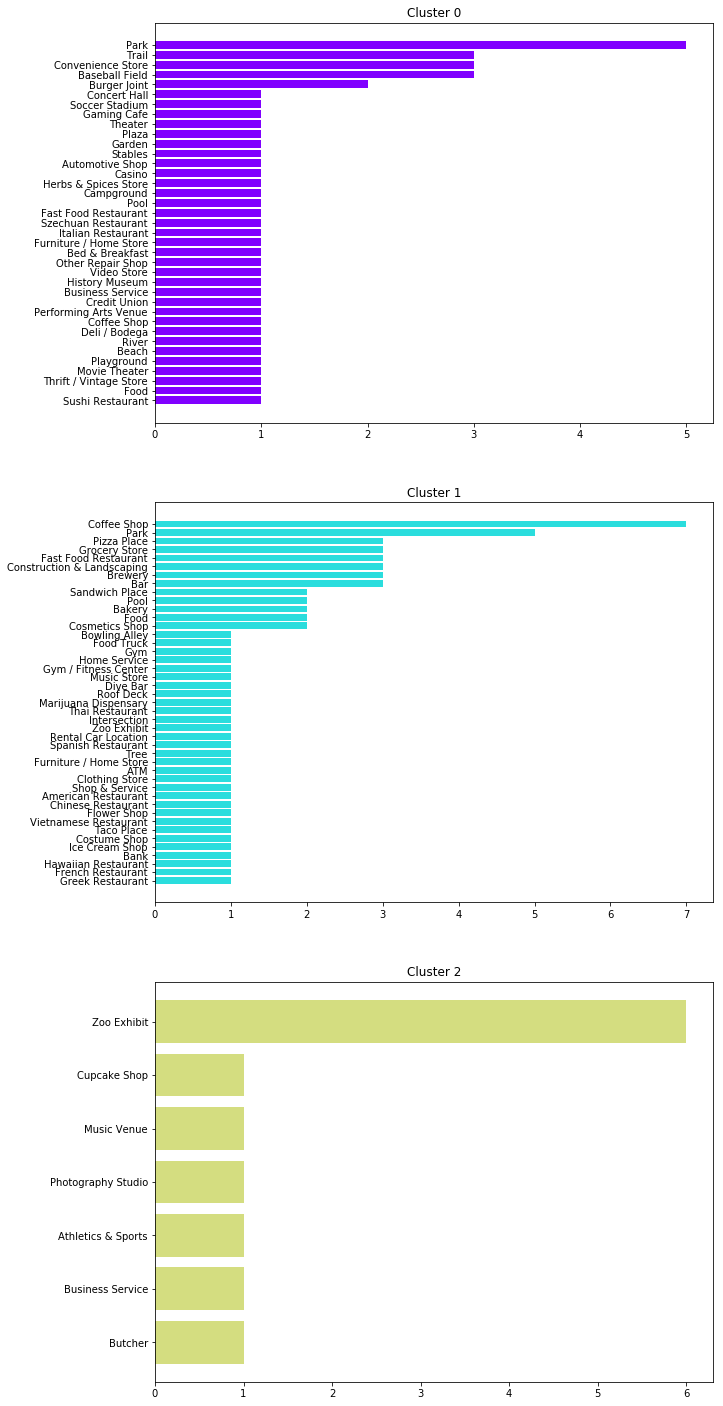

In [42]:
fig, ax = plt.subplots(3,1, figsize=(10,25))
cmap = cm.rainbow
for c in range(kclusters):
    cluster = neighborhoods_venue_names_sorted.loc[neighborhoods_venue_names_sorted['Cluster Labels'] == c, ['1st Most Common Venue','2nd Most Common Venue']]
    venue_list = []
    for i in cluster.columns:
        series_list = cluster[i].tolist()
        venue_list += series_list

    venue_list
    venue_series = pd.Series(venue_list)
    #venue_series.value_counts().values
    ax[c].barh(venue_series.value_counts().keys(), venue_series.value_counts().values, label=('Cluster %s' %c), 
               color=cmap(c / float(kclusters)))
    ax[c].set_title(('Cluster %s' %c))
    ax[c].invert_yaxis()
plt.show()

__Cluster 0__: Outdoor activities<br><br>
In cluster 0, we can clearly see that parks, fields, tracks and playgrouds are predominant. Along with it, we do see some shops, casino, and meusums as well. However, we do see some restaurants and other anomalies which might not fall within the category 'Outdoor activities', but the majority of the venues do fit into this description.<br><br>
__Cluster 1__: Cafes and restaurants<br><br>
Cluster 1 mostly comprises of coffee shops and a variety of restaurants. However, we do see a significant anomaly - 'park', the frequency of which is relatively high. But since most of the places belong to the category of eateries, we can safely tag this category as 'Cafes and restaurants'.<br><br>
__Cluster 2__: Zoo and misc.<br><br>
This cluster has a relatively high frequency of zoos. The other places are quite varied and do not seem to fit in a single category of venues. Probably they are built around the zoos.

Let us try to plot these clusters into a map to see how the distribution looks like:

In [43]:
zipcode_coo['zipcode'] = zipcode_coo['zipcode'].astype(int)
zipcode_coo['lat'] = zipcode_coo['lat'].astype(float)
zipcode_coo['lon'] = zipcode_coo['lon'].astype(float)

In [44]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kc_merged = pd.DataFrame()

#kc_house_data.drop(columns=['date', 'lat', 'long'], inplace=True)
kc_merged = neighborhoods_venue_names_sorted.merge(zipcode_coo, left_on='Neighborhood', right_on='zipcode', suffixes=('','zipcode_'))
kc_cluster_merged = kc_merged.merge(kc_house_data, left_on='Neighborhood', right_on='zipcode')

In [45]:
# create map
map_clusters = folium.Map(location=[kc_lat, kc_long], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kc_merged['lat'], kc_merged['lon'], kc_merged['Neighborhood'], kc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

Clusters 0 and 1 seem to be uniformly distributed througout whereas Cluster 2 seems to be towards the outskirts and do naot have much presence towards the centre. This makes sense, as playgrounds and restaurants can be found anywhere, whereas it would be better to have a zoo/sanctuary a bit away from the urban areas.

Now, as our final analysis, let us see what impact does these clusters have on housing prices. We will plot a scatter plot between these clusters and prices and try to find a correlation between them.

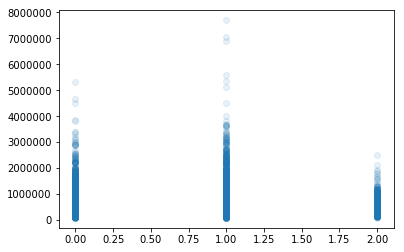

In [48]:
plt.scatter(kc_cluster_merged['Cluster Labels'], kc_cluster_merged['price'], alpha=0.1)
plt.show()

Interestingly, we can see a pattern emerging out of our clusters. It looks like houses in the neighborhoods which have more number of eateries have a greater range of house prices than the other two clusters. Even though the cluster seems to have outliers, we can say that the more expensive houses belong to this category.<br><br>
Furthermore, it can be said that houses in heighborhoods which have zoos, do not have a bigger range of selling prices. However, this cannot be very accurately said as we have limited data for this cluster.

<H1><font color='SteelBlue'>Conclusion

__Hence, I think that the division of cluster can be a fair addition to the set of features which can have an effect on housing prices. Since there is a coorelation that emerges out of this division, once we have access to more more data, it can be a good predictor in predicting the selling price of a house based on the venues around it.__